# End to end examples

## House King County

> https://mlr-org.com/gallery/2020-01-30-house-prices-in-king-county/

In [1]:
using Pkg ; Pkg.activate("D:/JULIA/6_ML_with_Julia/EX-housekingcounty"); Pkg.instantiate()

  Activating project at `D:\JULIA\6_ML_with_Julia\EX-housekingcounty`


> Getting started
> 1. Loading and preparing the data
> 2. Basic data visualisation

> Fitting a first model
> 1. Random forest model
> 2. GBM

### Getting started

---

### Loading and preparing the data

In [2]:
using MLJ
using PrettyPrinting
import DataFrames: DataFrame, select!, Not, describe
import Statistics
using Dates
using PyPlot
using UrlDownload

df = DataFrame(urldownload("https://raw.githubusercontent.com/tlienart/DataScienceTutorialsData.jl/master/data/kc_housing.csv", true))
describe(df)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,id,4.5803e9,1000102,3.90493e9,9900000190,0
2,date,,20140502T000000,,20150527T000000,0
3,price,5.40088e5,75000.0,450000.0,7.7e6,0
4,bedrooms,3.37084,0,3.0,33,0
5,bathrooms,2.11476,0.0,2.25,8.0,0
6,sqft_living,2079.9,290,1910.0,13540,0
7,sqft_lot,15107.0,520,7618.0,1651359,0
8,floors,1.49431,1.0,1.5,3.5,0
9,waterfront,0.00754176,0,0.0,1,0


We drop unrelated columns

In [3]:
select!(df, Not([:id, :date]))
schema(df)

┌───────────────┬────────────┬─────────┐
│ names         │ scitypes   │ types   │
├───────────────┼────────────┼─────────┤
│ price         │ Continuous │ Float64 │
│ bedrooms      │ Count      │ Int64   │
│ bathrooms     │ Continuous │ Float64 │
│ sqft_living   │ Count      │ Int64   │
│ sqft_lot      │ Count      │ Int64   │
│ floors        │ Continuous │ Float64 │
│ waterfront    │ Count      │ Int64   │
│ view          │ Count      │ Int64   │
│ condition     │ Count      │ Int64   │
│ grade         │ Count      │ Int64   │
│ sqft_above    │ Count      │ Int64   │
│ sqft_basement │ Count      │ Int64   │
│ yr_built      │ Count      │ Int64   │
│ yr_renovated  │ Count      │ Int64   │
│ zipcode       │ Count      │ Int64   │
│ lat           │ Continuous │ Float64 │
│ long          │ Continuous │ Float64 │
│ sqft_living15 │ Count      │ Int64   │
│ sqft_lot15    │ Count      │ Int64   │
└───────────────┴────────────┴─────────┘


Afterwards, we convert the zip code to an unordered factor (Multiclass), we also create two binary features isrenovated and has_basement derived from yr_renovated and sqft_basement:

In [4]:
coerce!(df, :zipcode => Multiclass)
df.isrenovated = @. !iszero(df.yr_renovated)
df.has_basement = @. !iszero(df.sqft_basement)

21613-element BitVector:
 0
 1
 0
 1
 0
 1
 0
 0
 1
 0
 1
 1
 0
 ⋮
 0
 0
 0
 0
 0
 1
 1
 0
 0
 0
 0
 0

In [5]:
schema(df)

┌───────────────┬────────────────┬─────────────────────────────────┐
│ names         │ scitypes       │ types                           │
├───────────────┼────────────────┼─────────────────────────────────┤
│ price         │ Continuous     │ Float64                         │
│ bedrooms      │ Count          │ Int64                           │
│ bathrooms     │ Continuous     │ Float64                         │
│ sqft_living   │ Count          │ Int64                           │
│ sqft_lot      │ Count          │ Int64                           │
│ floors        │ Continuous     │ Float64                         │
│ waterfront    │ Count          │ Int64                           │
│ view          │ Count          │ Int64                           │
│ condition     │ Count          │ Int64                           │
│ grade         │ Count          │ Int64                           │
│ sqft_above    │ Count          │ Int64                           │
│ sqft_basement │ Count          │

These created variables should be treated as OrderedFactor,

In [6]:
coerce!(df, :isrenovated => OrderedFactor, :has_basement => OrderedFactor);

The feature `waterfron`t is currently encoded as a string, but it's really just a boolean:

In [7]:
unique(df.waterfront)

2-element Vector{Int64}:
 0
 1

So let's recode it

In [8]:
df.waterfront = (df.waterfront .!="FALSE")
coerce!(df, :waterfront => OrderedFactor);

In [10]:
schema(df)

┌───────────────┬──────────────────┬─────────────────────────────────┐
│ names         │ scitypes         │ types                           │
├───────────────┼──────────────────┼─────────────────────────────────┤
│ price         │ Continuous       │ Float64                         │
│ bedrooms      │ Count            │ Int64                           │
│ bathrooms     │ Continuous       │ Float64                         │
│ sqft_living   │ Count            │ Int64                           │
│ sqft_lot      │ Count            │ Int64                           │
│ floors        │ Continuous       │ Float64                         │
│ waterfront    │ OrderedFactor{1} │ CategoricalValue{Bool, UInt32}  │
│ view          │ Count            │ Int64                           │
│ condition     │ Count            │ Int64                           │
│ grade         │ Count            │ Int64                           │
│ sqft_above    │ Count            │ Int64                           │
│ sqft

For a number of the remaining features which are treated as `Count` there are few unique values in which case it might make more sense to recode them as OrderedFactor, this can be done with `autotype`:

In [11]:
coerce!(df, autotype(df, :few_to_finite))
schema(df)

┌───────────────┬───────────────────┬───────────────────────────────────┐
│ names         │ scitypes          │ types                             │
├───────────────┼───────────────────┼───────────────────────────────────┤
│ price         │ Continuous        │ Float64                           │
│ bedrooms      │ OrderedFactor{13} │ CategoricalValue{Int64, UInt32}   │
│ bathrooms     │ OrderedFactor{30} │ CategoricalValue{Float64, UInt32} │
│ sqft_living   │ Count             │ Int64                             │
│ sqft_lot      │ Count             │ Int64                             │
│ floors        │ OrderedFactor{6}  │ CategoricalValue{Float64, UInt32} │
│ waterfront    │ OrderedFactor{1}  │ CategoricalValue{Bool, UInt32}    │
│ view          │ OrderedFactor{5}  │ CategoricalValue{Int64, UInt32}   │
│ condition     │ OrderedFactor{5}  │ CategoricalValue{Int64, UInt32}   │
│ grade         │ OrderedFactor{12} │ CategoricalValue{Int64, UInt32}   │
│ sqft_above    │ Count             │ 

Let's also rescale the column `price` to be 1000s the dollars:

In [13]:
df.price = df.price ./ 1000;

For simplicity let's just drop a few additional columns that don't seem to matter much:

In [14]:
select!(df, Not([:yr_renovated, :sqft_basement, :zipcode]));

### Basic data visualisation

Let's plot a basic histogram of the prices to get an idea for the distribution:

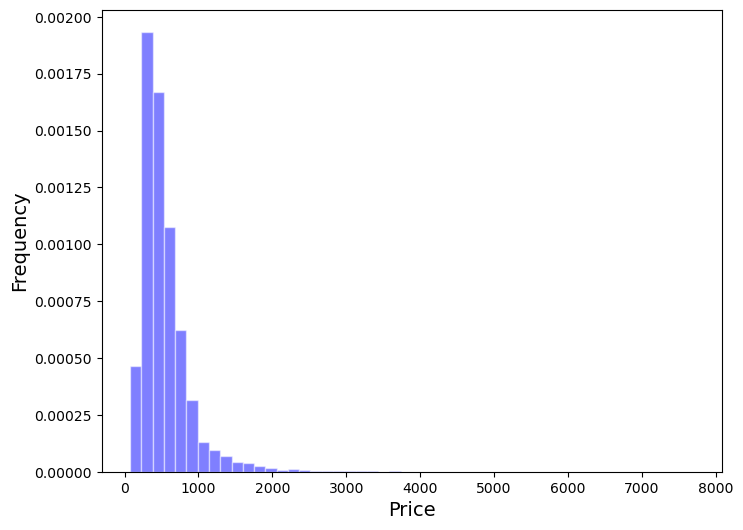

In [16]:
plt.figure(figsize = (8,6))
plt.hist(df.price, color = "blue", edgecolor = "white", bins=50, density = true, alpha = 0.5)
plt.xlabel("Price", fontsize = 14)
plt.ylabel("Frequency", fontsize = 14)
savefig("./plots/4.6.1.png")

Let's see if there's a difference between renovated and unrenovated flats:

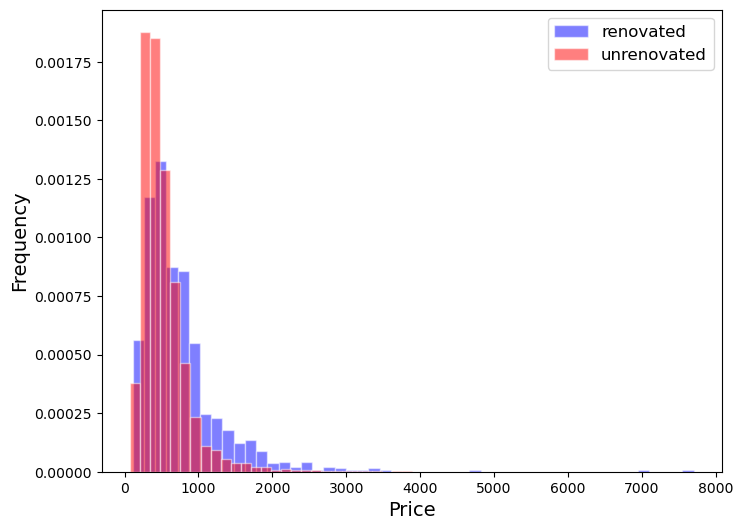

In [17]:
plt.figure(figsize=(8,6))
plt.hist(df.price[df.isrenovated .== true], color = "blue", density=true, 
        edgecolor = "white", bins = 50, label = "renovated", alpha = 0.5)
plt.hist(df.price[df.isrenovated .== false], color = "red", density = true,
        edgecolor = "white", bins = 50, label = "unrenovated", alpha = 0.5)
plt.xlabel("Price", fontsize = 14)
plt.ylabel("Frequency", fontsize = 14)
plt.legend(fontsize = 12)
savefig("./plots/4.6.2.png")

We can observe that renovated flats seem to achieve higher sales values, and this might thus be a relevant feature.

Likewise, this could be done to verify that `condition`, `waterfront` etc are important features.

### Fitting a first model

---

In [19]:
DTR = @load DecisionTreeRegressor pkg=DecisionTree

y, X = unpack(df, ==(:price))
train, test = partition(collect(eachindex(y)), 0.7, shuffle=true, rng=5)

import MLJDecisionTreeInterface ✔

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


([20388, 12132, 8870, 14461, 13025, 5446, 16753, 1028, 2583, 21485  …  15174, 7564, 3237, 8924, 19348, 11333, 16320, 21245, 8848, 16496], [6769, 15022, 2162, 6993, 7712, 13989, 18130, 3744, 20210, 18819  …  13967, 6209, 4581, 10476, 18052, 10550, 20320, 12354, 4103, 997])

In [20]:
tree = machine(DTR(), X, y)

Machine{DecisionTreeRegressor,…} trained 0 times; caches data
  model: MLJDecisionTreeInterface.DecisionTreeRegressor
  args: 
    1:	Source @406 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Count}, AbstractVector{OrderedFactor{30}}, AbstractVector{OrderedFactor{13}}, AbstractVector{OrderedFactor{6}}, AbstractVector{OrderedFactor{1}}, AbstractVector{OrderedFactor{12}}, AbstractVector{OrderedFactor{5}}, AbstractVector{OrderedFactor{2}}}}`
    2:	Source @536 ⏎ `AbstractVector{Continuous}`


In [21]:
fit!(tree, rows = train)

┌ Info: Training Machine{DecisionTreeRegressor,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


Machine{DecisionTreeRegressor,…} trained 1 time; caches data
  model: MLJDecisionTreeInterface.DecisionTreeRegressor
  args: 
    1:	Source @406 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Count}, AbstractVector{OrderedFactor{30}}, AbstractVector{OrderedFactor{13}}, AbstractVector{OrderedFactor{6}}, AbstractVector{OrderedFactor{1}}, AbstractVector{OrderedFactor{12}}, AbstractVector{OrderedFactor{5}}, AbstractVector{OrderedFactor{2}}}}`
    2:	Source @536 ⏎ `AbstractVector{Continuous}`


Let's see how it does

In [22]:
rms(y[test], MLJ.predict(tree, rows = test))

179.62279406715433

Let's try to do better.

### Random forest model

We might be able to improve upon the RMSE using more powerful learners.

In [23]:
RFR = @load RandomForestRegressor pkg = ScikitLearn

import MLJScikitLearnInterface

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


 ✔


MLJScikitLearnInterface.RandomForestRegressor

That model only accepts input in the form of `Count` and so we have to coerce all `Finite` types into `Count`:

In [24]:
coerce!(X, Finite => Count);

Now we can fit

In [25]:
rf_mdl = RFR()
rf = machine(rf_mdl, X, y)
fit!(rf, rows = train)

rms(y[test], MLJ.predict(rf, rows = test))

┌ Info: Training Machine{RandomForestRegressor,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
C:\Users\jeffr\.julia\conda\3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\jeffr\.julia\conda\3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


136.05056190268132

A bit better but it would be best to check this a bit more carefully:

In [27]:
cv3 = CV(; nfolds = 3)
res = evaluate(rf_mdl, X, y, 
                resampling = CV(shuffle = true), 
                measure = rms,
                verbosity=0)

C:\Users\jeffr\.julia\conda\3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\jeffr\.julia\conda\3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\jeffr\.julia\conda\3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\jeffr\.julia\conda\3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in ver

PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌────────────────────────┬─────────────┬───────────┬────────────────────────────
│ measure                │ measurement │ operation │ per_fold                  ⋯
├────────────────────────┼─────────────┼───────────┼────────────────────────────
│ RootMeanSquaredError() │ 133.0       │ predict   │ [136.0, 122.0, 135.0, 143 ⋯
└────────────────────────┴─────────────┴───────────┴────────────────────────────
                                                                1 column omitted


### GBM

Let's try a different kind of model: Gradient Boosted Decision Trees from the package xgboost and we'll try to tune it too.

In [28]:
XGBR = @load XGBoostRegressor

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


import MLJXGBoostInterface

┌ Info: Precompiling MLJXGBoostInterface [54119dfa-1dab-4055-a167-80440f4f7a91]
└ @ Base loading.jl:1423


 ✔


MLJXGBoostInterface.XGBoostRegressor

It expects a `Table(Continuous)` input so we need to coerce `X` again:

In [29]:
coerce!(X, Count => Continuous)

xgb = XGBR()
xgbm = machine(xgb, X, y)
fit!(xgbm, rows = train)

rms(y[test], MLJ.predict(xgbm, rows = test))

┌ Info: Training Machine{XGBoostRegressor,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
[1]	train-rmse:473.111572
[2]	train-rmse:350.285614
[3]	train-rmse:265.503052
[4]	train-rmse:208.657257
[5]	train-rmse:170.213760
[6]	train-rmse:145.523315
[7]	train-rmse:130.098495
[8]	train-rmse:119.091690
[9]	train-rmse:111.952690
[10]	train-rmse:106.143631
[11]	train-rmse:102.771286
[12]	train-rmse:100.355171
[13]	train-rmse:97.779922
[14]	train-rmse:95.792801
[15]	train-rmse:94.666229
[16]	train-rmse:92.975121
[17]	train-rmse:91.769394
[18]	train-rmse:90.871758
[19]	train-rmse:90.187813
[20]	train-rmse:88.994667
[21]	train-rmse:88.244354
[22]	train-rmse:87.721588
[23]	train-rmse:86.377625
[24]	train-rmse:85.511894
[25]	train-rmse:84.802544
[26]	train-rmse:82.886734
[27]	train-rmse:82.143959
[28]	train-rmse:81.660629
[29]	train-rmse:80.735031
[30]	train-rmse:79.906212
[31]	train-rmse:79.602722
[32]	train-rmse:79.059151
[33]	train-rmse:78.195908
[34]	train-rmse:

137.35137858698184

Let's try to tune it, first we define ranges for a number of useful parameters:

In [30]:
r1 = range(xgb, :max_depth, lower = 3, upper = 10)
r2 = range(xgb, :num_round, lower = 1, upper = 25);

And now we tune, we use a very coarse resolution because we use so many ranges, ```2^7``` is already some 128 models...

In [32]:
tm = TunedModel(model = xgb, 
                tuning=Grid(resolution=7), 
                resampling = CV(rng=11), 
                ranges = [r1, r2], 
                measure = rms)

DeterministicTunedModel(
    model = XGBoostRegressor(
            num_round = 100,
            booster = "gbtree",
            disable_default_eval_metric = 0,
            eta = 0.3,
            gamma = 0.0,
            max_depth = 6,
            min_child_weight = 1.0,
            max_delta_step = 0.0,
            subsample = 1.0,
            colsample_bytree = 1.0,
            colsample_bylevel = 1.0,
            lambda = 1.0,
            alpha = 0.0,
            tree_method = "auto",
            sketch_eps = 0.03,
            scale_pos_weight = 1.0,
            updater = "auto",
            refresh_leaf = 1,
            process_type = "default",
            grow_policy = "depthwise",
            max_leaves = 0,
            max_bin = 256,
            predictor = "cpu_predictor",
            sample_type = "uniform",
            normalize_type = "tree",
            rate_drop = 0.0,
            one_drop = 0,
            skip_drop = 0.0,
            feature_selector = "cyclic",
        

In [33]:
mtm = machine(tm, X, y)
fit!(mtm, rows = train)

┌ Info: Training Machine{DeterministicTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Attempting to evaluate 49 models.
└ @ MLJTuning C:\Users\jeffr\.julia\packages\MLJTuning\Al9yX\src\tuned_models.jl:680
Evaluating over 49 metamodels: 100%[=========================] Time: 0:00:49


Machine{DeterministicTunedModel{Grid,…},…} trained 1 time; caches data
  model: MLJTuning.DeterministicTunedModel{Grid, MLJXGBoostInterface.XGBoostRegressor}
  args: 
    1:	Source @038 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @579 ⏎ `AbstractVector{Continuous}`


In [34]:
rms(y[test], MLJ.predict(mtm, rows = test))

145.8097421015522